[413.09842693 531.11086696 218.17855418 383.1207039 ]


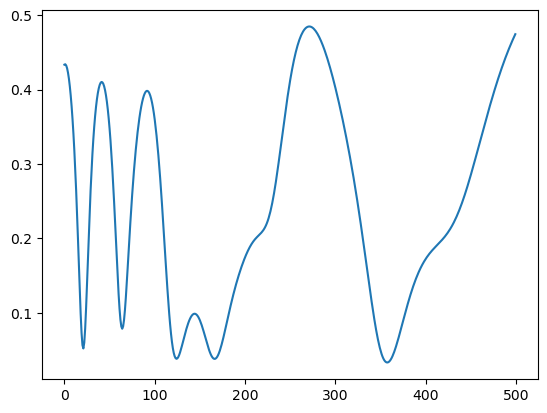

In [3]:
import sys
sys.path.append('./../../designer/script/')
from gets.get_spectrum import get_spectrum_simple
from film import FilmSimple
from spectrum import SpectrumSimple
from utils.plot_spectrum import plot_spectrum
import numpy as np
import copy
import matplotlib.pyplot as plt

WLS = np.linspace(500, 1000, 500)
INC_ANG = 60.
layer_number = 4
seed = 3

np.random.seed(seed)
d = np.random.random(layer_number) * 3000 / layer_number
print(d)
f = FilmSimple('SiO2', 'TiO2', 'SiO2', d)
f.add_spec_param(INC_ANG, WLS)
f.calculate_spectrum()
spec = f.get_spec().get_R()

np.savetxt(f"generaetd_spectrum-INC_ANG{INC_ANG}-WLS{WLS[0]}to{WLS[-1]}-R_{layer_number}layers_seed{seed}.txt", spec)
plt.plot(spec)




In [2]:
print("n TiO2 at 750 nm", f.get_spec().n[250, 1])
print("n SiO2 at 750 nm", f.get_spec().n[250, 0])
print(f.get_optical_thickness(750))

n TiO2 at 750 nm (2.5334627507835505+0j)
n SiO2 at 750 nm (1.5393841396519676+0j)
(2014.4583274965441+0j)
